## Case 3: Model to differentiate between the food and the interior of a restaurant

Imagine the tripadvisor application being able to filter pictures of restaurants to just show the food or just show how the restaurants looks. Showing the food could be useful to get an idea of what you will get on your plate whilst showing the interior of the restaurant could be useful to get an idea of the atmosphere of the restaurant.

<i>NOTE: While I refer to 'interior' I mean everything that is not food so this might include outdoor seating areas, bars, etc. aswell.</i>

The first step in this project is to look for labelled data. The dataset that are being used here are available for download from the sources below:
- https://food-x.s3.amazonaws.com/test.tar --> 28.000+ images
> This dataset contains over 28.000 images of food. All these images will be used to train the model.

- http://web.mit.edu/torralba/www/indoor.html?fbclid=IwAR3WqfdpgOuq7fzeDxHaHqpcZDUXzdsLHSHz1xYf5iDDu74f7zk1zwWJe7w --> 2.4GB
> This dataset contains picture of indoor scenes, neatly put in folders depending on the category. For this project purpose we only used the images inside the folders 'restaurant', 'restaurant_kitchen', 'dining_room', 'bar' and 'fastfood_restaurant'.

The images gathered from both sources will be used to train the model to be able to differentiate between interior and food.

### Imports

In [58]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageOps
import glob
import PIL
import cv2
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import time
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import silhouette_visualizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix


Images are loaded in and resized to 128x128 pixels, flattened and put in a list.

Food images

In [2]:
images_food = []
food_folders = ["Images/buffet/*.jpg", 
                "Images/food/*.jpg"]

# putting all images in a dict where the key is the name of the picture
for folder in food_folders:
    fileNameList = glob.glob(folder)
    for fileName in tqdm(fileNameList, total=len(fileNameList)):
        try:
            img = Image.open(f"{fileName}")
            img = img.resize((128,128))
            img_np = np.array(img).flatten()
            images_food.append(img_np / 255)
        except PIL.UnidentifiedImageError:
            pass

100%|██████████| 28377/28377 [01:43<00:00, 273.77it/s]


Interior images

In [3]:
images_interior = []
interior_folders = ["Images/restaurant/*.jpg", 
                    "Images/restaurant_kitchen/*.jpg", 
                    "Images/dining_room/*.jpg", 
                    "Images/bar/*.jpg",
                    "Images/fastfood_restaurant/*.jpg"]

for folder in interior_folders:
    fileNameList = glob.glob(folder)
    for fileName in tqdm(fileNameList, total=len(fileNameList)):
        try:
            img = Image.open(f"{fileName}")
            img = img.resize((128,128))
            img_np = np.array(img).flatten()
            images_interior.append(img_np / 255)
        except PIL.UnidentifiedImageError:
            pass

100%|██████████| 116/116 [00:01<00:00, 70.87it/s]


To visualize what the HOG features look like a random image is chosen and the HOG features are plotted. (as shown in lab 3)

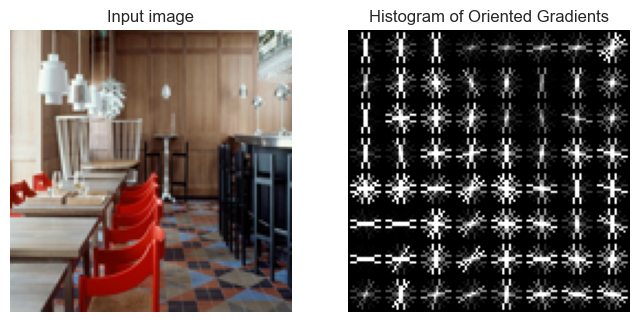

In [4]:
# HOG features example

fd, hog_image = hog(img,orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

Applying the HOG features to all the images and putting them in a list. This is done for both the interior and food images.

In [5]:
# HOG features for all interior images

images_interior = np.array(images_interior)

images_interior_hogs = np.zeros((images_interior.shape[0], 512 * 3))

for i, img in tqdm(enumerate(images_interior), total=len(images_interior)):

    if len(img) != 49152:
        continue
    
    img = img.reshape((128,128,3))
    for channel in range(3):
        fd = hog(img[:,:,channel] ,orientations=8, pixels_per_cell=(16, 16),
                cells_per_block=(1, 1), visualize=False, feature_vector=True)
        images_interior_hogs[i, channel*512:channel*512+512] = fd

/var/folders/4l/gsvsrpxd2kqb4f6v1wy203b80000gn/T/ipykernel_4662/1772100697.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images_interior = np.array(images_interior)
100%|██████████| 1613/1613 [00:13<00:00, 123.66it/s]


In [6]:
# HOG features for all food images

images_food = np.array(images_food)

images_food_hogs = np.zeros((images_food.shape[0], 512 * 3))

for i, img in tqdm(enumerate(images_food), total=len(images_food)):
    if len(img) != 49152:
        continue
    
    img = img.reshape((128,128,3))
    for channel in range(3):
        fd = hog(img[:,:,channel] ,orientations=8, pixels_per_cell=(16, 16),
                cells_per_block=(1, 1), visualize=False, feature_vector=True)
        images_food_hogs[i, channel*512:channel*512+512] = fd


/var/folders/4l/gsvsrpxd2kqb4f6v1wy203b80000gn/T/ipykernel_4662/145864873.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images_food = np.array(images_food)
100%|██████████| 28488/28488 [04:44<00:00, 100.08it/s]


Next, we will create a dataframe with the HOG features and the labels. All images from the food dataset will be labelled as 'food' and all images from the interior dataset will be labelled as 'interior'.

In [47]:
df_interior = pd.DataFrame(images_interior_hogs)
# add a column (in the beginning) with the label "interior"
df_interior.insert(0, "label", "interior")

df_food = pd.DataFrame(images_food_hogs)
# add a column (in the beginning) with the label "food"
df_food.insert(0, "label", "food")

df = pd.concat([df_interior, df_food], ignore_index=True)

# shuffle the rows
df = df.sample(frac=1).reset_index(drop=True)

df.head(5)

,label,0,1,2,3,4,5,6,7,8,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
0,food,0.491510,0.491510,0.463985,0.030929,0.219960,0.035556,0.096790,0.491510,0.406008,...,0.216584,0.533872,0.669055,0.111221,0.079243,0.041038,0.116199,0.033891,0.264094,0.669055
1,food,0.439077,0.407890,0.439077,0.239523,0.439077,0.439077,0.071412,0.000000,0.515554,...,0.572665,0.572665,0.560948,0.042824,0.048830,0.060286,0.117510,0.103443,0.571391,0.571391
2,interior,0.373559,0.373559,0.364589,0.373559,0.373559,0.172621,0.373559,0.373559,0.398667,...,0.331946,0.231318,0.362589,0.077508,0.250869,0.437769,0.437769,0.437769,0.437769,0.181715
3,food,0.133961,0.139277,0.554557,0.554557,0.554557,0.147393,0.111870,0.076265,0.202157,...,0.119447,0.124413,0.381679,0.381679,0.381679,0.381679,0.381679,0.217897,0.280082,0.381679
4,food,0.382153,0.382153,0.382153,0.382153,0.382153,0.194060,0.293423,0.382153,0.411315,...,0.436409,0.047886,0.457792,0.361813,0.451835,0.000000,0.457792,0.155387,0.457792,0.109875


Next we will split the data into a training and test set. The training set will be used to train the model and the test set will be used to test the model. The test set will be 20% of the total dataset. After that we will use the trained model to predict the correct label of the pictures that are given in the tripadvisor images dataset.

We will try out different models to see which one performs the best. The models that will be used are:
- RandomForestClassifier
- AdaBoostClassifier
- ExtraTreesClassifier

We will compare the models by looking at the accuracy score and the confusion matrix.

In [48]:
# All the pixels data goes into X
X = df.drop(columns=["label"])
# The labels go into y (the target)
y = df["label"]

# Splitting dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

0.9539943530974921


In [75]:
# Using the RandomForestClassifier
model_rfc = RandomForestClassifier(random_state=0)
model_rfc.fit(X_train, y_train)
y_pred = model_rfc.predict(X_test)
predictions = model_rfc.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, y_pred))

[[5717    1]
 [ 259   44]]
              precision    recall  f1-score   support

        food       0.96      1.00      0.98      5718
    interior       0.98      0.15      0.25       303

    accuracy                           0.96      6021
   macro avg       0.97      0.57      0.62      6021
weighted avg       0.96      0.96      0.94      6021

0.9568178043514366


In [76]:
# Using the AdaBoostClassifier
model_abc = AdaBoostClassifier(random_state=0)
model_abc.fit(X_train, y_train)
y_pred = model_abc.predict(X_test)
predictions = model_abc.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, y_pred))

[[5659   59]
 [ 106  197]]
              precision    recall  f1-score   support

        food       0.98      0.99      0.99      5718
    interior       0.77      0.65      0.70       303

    accuracy                           0.97      6021
   macro avg       0.88      0.82      0.85      6021
weighted avg       0.97      0.97      0.97      6021

0.9725959142999502


The confusion matrix shows that the model is able to predict the correct label for the images in the test set for over 5700 images of the total 6021 images. This corresponds to an accuracy score of 97%. We also see that we have 106 false negatives and 197 true negatives, which corresponds to 1.8% and 3.3% of the total test set respectively.

In [77]:
# Using the ExtraTreesClassifier
model_etc = ExtraTreesClassifier(random_state=0)
model_etc.fit(X_train, y_train)
y_pred = model_etc.predict(X_test)
predictions = model_etc.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, y_pred))

[[5718    0]
 [ 277   26]]
              precision    recall  f1-score   support

        food       0.95      1.00      0.98      5718
    interior       1.00      0.09      0.16       303

    accuracy                           0.95      6021
   macro avg       0.98      0.54      0.57      6021
weighted avg       0.96      0.95      0.94      6021

0.9539943530974921


The confusion matrix shows that the model is able to predict the correct label for the images in the test set for over 5700 images of the total 6021 images. This corresponds to an accuracy score of 95%. We also see that we have about 277 false negatives which corresponds to about 4.6% of the total images.

Note that all models seem to perform very well, but altough this figure might seem high, it is important to note that this does not mean that the model will be able to predict the correct label for all the images in the tripadvisor dataset. The model is only trained on images of food and interior of restaurants. The tripadvisor dataset contains images of other things aswell, such as people, animals, etc. The model will not be able to predict the correct label for these images.

Now that the model has been trained we can use it to predict the labels of the images in the tripadvisor dataset. The images will be loaded in and resized to 128x128 pixels, flattened and put in a list. The HOG features will be extracted from the images and put in a list.

In [51]:
# Load images from tripadvisor

images_tripadivsor = []
folder_images_tripadvisor = ["tripadvisor_dataset/tripadvisor_images/*.jpg"]


# putting all images in a dict where the key is the name of the picture
for folder in folder_images_tripadvisor:
    fileNameList = glob.glob(folder)
    for fileName in tqdm(fileNameList, total=len(fileNameList)):
        try:
            img = Image.open(f"{fileName}")
            img = img.resize((128,128))
            img_np = np.array(img).flatten()
            images_tripadivsor.append(img_np / 255)
        except PIL.UnidentifiedImageError:
            pass

100%|██████████| 15183/15183 [01:04<00:00, 233.71it/s]


In [52]:
# HOG features for all tripadvisor images

images_tripadivsor = np.array(images_tripadivsor)

images_tripadivsor_hogs = np.zeros((images_tripadivsor.shape[0], 512 * 3))

for i, img in tqdm(enumerate(images_tripadivsor), total=len(images_tripadivsor)):
    if len(img) != 49152:
        continue
    
    img = img.reshape((128,128,3))
    for channel in range(3):
        fd = hog(img[:,:,channel] ,orientations=8, pixels_per_cell=(16, 16),
                cells_per_block=(1, 1), visualize=False, feature_vector=True)
        images_tripadivsor_hogs[i, channel*512:channel*512+512] = fd

/var/folders/4l/gsvsrpxd2kqb4f6v1wy203b80000gn/T/ipykernel_4662/757852675.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images_tripadivsor = np.array(images_tripadivsor)
100%|██████████| 15182/15182 [02:05<00:00, 121.22it/s]


We create y_pred, which is a list of the predicted labels for the images in the tripadvisor dataset. The labels are either 'food' or 'interior'. We will also add a score column to the dataframe. This score will be the probability that the model gives to the image to be food (or interior). The higher the score, the more likely it is that the image is food (or interior). We will compare the average score of the images that are labelled as food with the average score of the images that are labelled as interior for the three different models.

In [103]:
def use_model(model):
    # Use the model to predict if img is food or interior and show the result
    y_pred = model.predict(images_tripadivsor_hogs)

    df_tripadvisor = pd.DataFrame(images_tripadivsor_hogs)
    df_tripadvisor.insert(0, "label", y_pred)

    # Add a column with the score of the prediction
    df_tripadvisor["score"] = model.predict_proba(df_tripadvisor.drop(columns=["label"]))[:,1]

    # Get the average score of images that are predicted to be food
    average_score_food = df_tripadvisor[df_tripadvisor["label"] == "food"]["score"].mean()
    print(f"Average score of food: {average_score_food}")

    # Get the average score of images that are predicted to be interior
    average_interior_score = df_tripadvisor[df_tripadvisor["label"] == "interior"]["score"].mean()
    print(f"Average score of interior: {average_interior_score}")


    return df_tripadvisor

print("Using RandomForestClassifier:")
use_model(model_rfc)
print("Using AdaBoostClassifier:")
use_model(model_abc)
print("Using ExtraTreesClassifier:")
use_model(model_etc)

Using RandomForestClassifier:
Average score of food: 0.11958027051098082
Average score of interior: 0.5839283688473753
Using AdaBoostClassifier:
Average score of food: 0.46005609758935995
Average score of interior: 0.5150821413920513
Using ExtraTreesClassifier:
Average score of food: 0.12173268660738346
Average score of interior: 0.5692011834319526


,label,0,1,2,3,4,5,6,7,8,...,1527,1528,1529,1530,1531,1532,1533,1534,1535,score
0,food,0.694380,0.037369,0.081553,0.080557,0.126928,0.026779,0.065634,0.694380,0.496936,...,0.074551,0.289653,0.294885,0.409667,0.531630,0.531630,0.275797,0.090971,0.108236,0.02
1,food,0.293957,0.005085,0.056443,0.313644,0.482654,0.482654,0.482654,0.336364,0.435894,...,0.355031,0.358345,0.358345,0.358345,0.358345,0.358345,0.358345,0.358345,0.317997,0.00
2,food,0.390940,0.372093,0.092118,0.390940,0.390940,0.390940,0.390940,0.298146,0.254545,...,0.030798,0.178551,0.624765,0.624765,0.345601,0.246266,0.057356,0.053667,0.034654,0.01
3,food,0.367816,0.367816,0.367816,0.367816,0.367816,0.230168,0.367816,0.367816,0.410911,...,0.306169,0.433506,0.251128,0.211344,0.246142,0.334721,0.394793,0.433506,0.433506,0.00
4,food,0.421868,0.415738,0.421868,0.421868,0.421868,0.174755,0.155027,0.246373,0.545003,...,0.353553,0.379670,0.379670,0.238415,0.279752,0.379670,0.379670,0.379670,0.379670,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15177,food,0.417610,0.224750,0.216466,0.175040,0.417610,0.417610,0.417610,0.417610,0.373562,...,0.353553,0.356631,0.356631,0.356631,0.356631,0.356631,0.356631,0.331211,0.356631,0.29
15178,food,0.391923,0.131862,0.246965,0.391923,0.391923,0.391923,0.391923,0.391923,0.349920,...,0.372572,0.353658,0.353658,0.353658,0.353658,0.353658,0.353658,0.352823,0.353658,0.16
15179,food,0.448088,0.448088,0.084933,0.195965,0.448088,0.448088,0.256577,0.292268,0.615739,...,0.236482,0.361305,0.354558,0.361305,0.361305,0.361305,0.333248,0.361305,0.332460,0.08
15180,food,0.544579,0.544579,0.318063,0.123707,0.329503,0.184212,0.156018,0.351498,0.450552,...,0.353553,0.354465,0.354465,0.354465,0.354465,0.354465,0.347109,0.354465,0.354465,0.05


The AdaBoostClassifier gives us the best prediction score of food and interior combined. Let's look at some pictures that are labelled as food and interior by the model.

In [104]:
df_tripadvisor_abc = use_model(model_abc)

Average score of food: 0.46005609758935995
Average score of interior: 0.5150821413920513


In [ ]:

fig, axs = plt.subplots(5, 5, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(25):
    #df_tripadvisor_interior_series = df_tripadvisor_interior.to_numpy()
    img = images_tripadivsor[i].reshape((128,128,3))
    axs[i].imshow(img)
    axs[i].set_title(df_tripadvisor_interior.iloc[i, 0])
    axs[i].text(0, 0, df_tripadvisor_interior.iloc[i, 0], color='orange', bbox=dict(facecolor='white', alpha=1))
    axs[i].text(0, 120, round(df_tripadvisor_interior.iloc[i, 1:].max(), 2), color='black', bbox=dict(facecolor='white', alpha=1))
    axs[i].axis('off')

plt.show()

In [140]:
df_tripadvisor_abc[(df_tripadvisor_abc["label"] == "food") & (df_tripadvisor_abc["score"] > 0.01)].head(30)

,label,0,1,2,3,4,5,6,7,8,...,1527,1528,1529,1530,1531,1532,1533,1534,1535,score
0,food,0.694380,0.037369,0.081553,0.080557,0.126928,0.026779,0.065634,0.694380,0.496936,...,0.074551,0.289653,0.294885,0.409667,0.531630,0.531630,0.275797,0.090971,0.108236,0.497508
1,food,0.293957,0.005085,0.056443,0.313644,0.482654,0.482654,0.482654,0.336364,0.435894,...,0.355031,0.358345,0.358345,0.358345,0.358345,0.358345,0.358345,0.358345,0.317997,0.436873
2,food,0.390940,0.372093,0.092118,0.390940,0.390940,0.390940,0.390940,0.298146,0.254545,...,0.030798,0.178551,0.624765,0.624765,0.345601,0.246266,0.057356,0.053667,0.034654,0.409647
3,food,0.367816,0.367816,0.367816,0.367816,0.367816,0.230168,0.367816,0.367816,0.410911,...,0.306169,0.433506,0.251128,0.211344,0.246142,0.334721,0.394793,0.433506,0.433506,0.432176
4,food,0.421868,0.415738,0.421868,0.421868,0.421868,0.174755,0.155027,0.246373,0.545003,...,0.353553,0.379670,0.379670,0.238415,0.279752,0.379670,0.379670,0.379670,0.379670,0.474024
5,food,0.397948,0.397948,0.397948,0.196292,0.397948,0.276998,0.304843,0.397948,0.393639,...,0.043671,0.442202,0.236035,0.255573,0.132424,0.442202,0.281538,0.442202,0.442202,0.464029
6,food,0.447012,0.130983,0.447012,0.447012,0.447012,0.375066,0.207102,0.000000,0.518238,...,0.000000,0.474769,0.307563,0.474769,0.000000,0.474769,0.061513,0.474769,0.000000,0.446879
7,food,0.395051,0.395051,0.395051,0.160449,0.395051,0.395051,0.395051,0.194590,0.410363,...,0.144760,0.448135,0.448135,0.295061,0.397677,0.448135,0.216856,0.206773,0.250071,0.471793
9,food,0.419288,0.263803,0.416304,0.419288,0.419288,0.302870,0.211010,0.305672,0.387548,...,0.051414,0.243837,0.112806,0.304214,0.500908,0.500908,0.425240,0.369112,0.127994,0.454783
10,food,0.571955,0.049328,0.121170,0.000000,0.571955,0.011621,0.036748,0.571955,0.465007,...,0.423792,0.712838,0.004388,0.031428,0.000000,0.695015,0.020814,0.042476,0.074645,0.459955


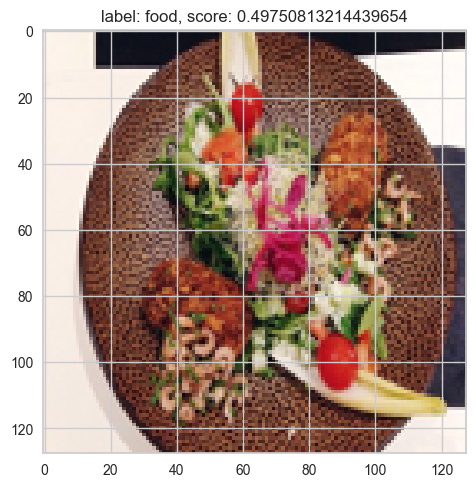

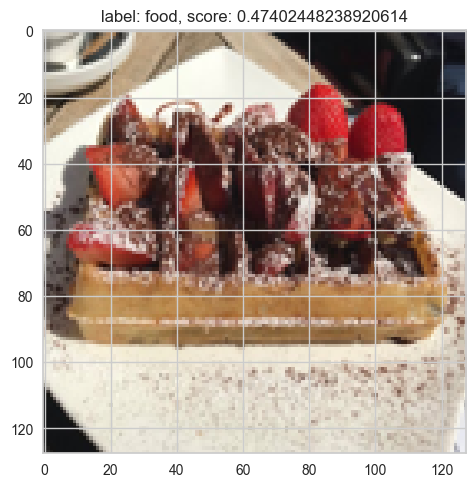

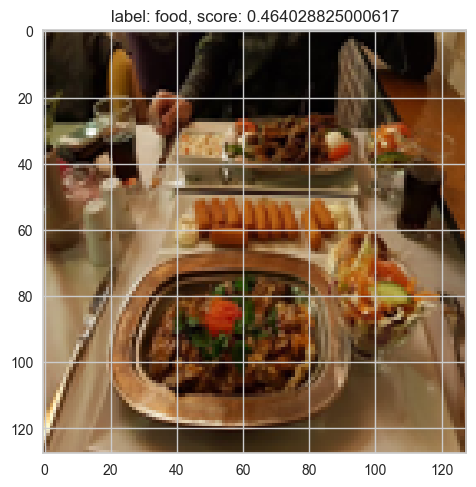

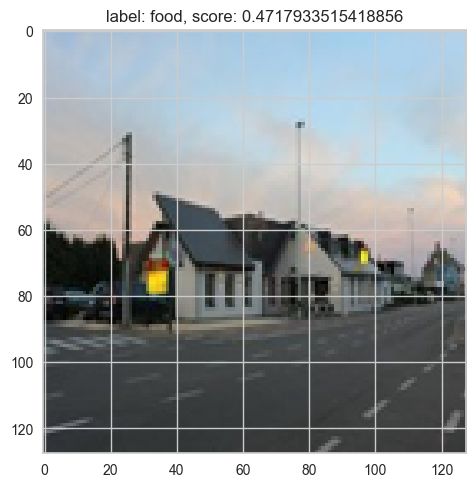

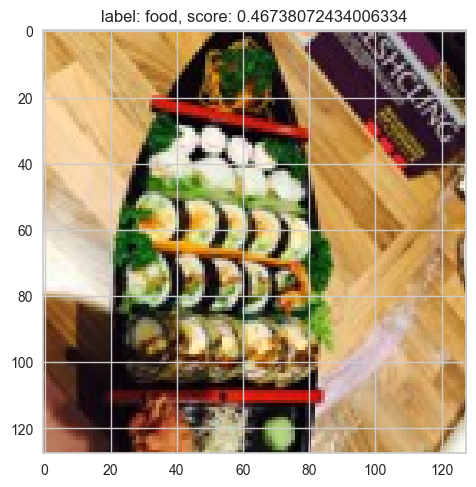

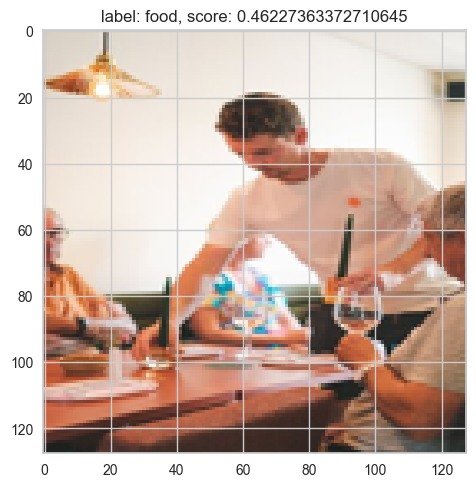

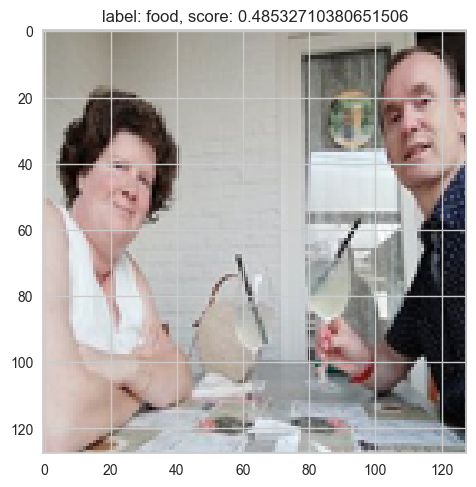

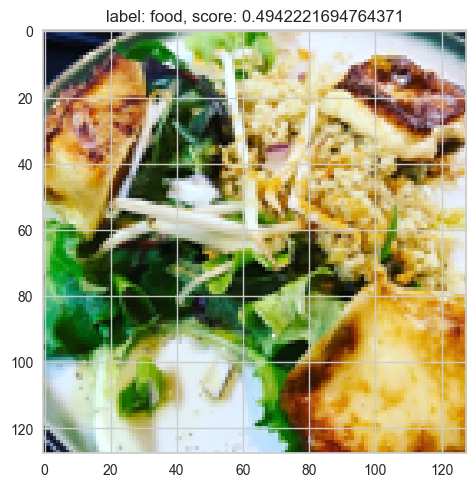

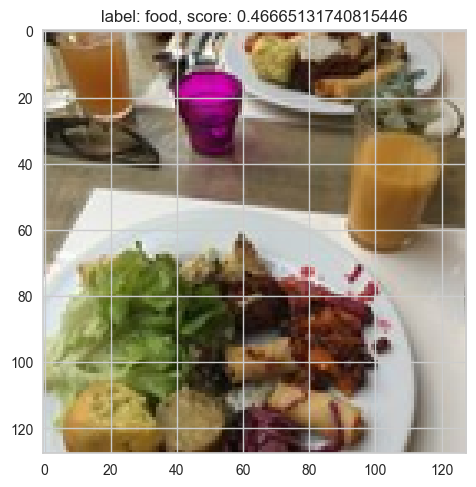

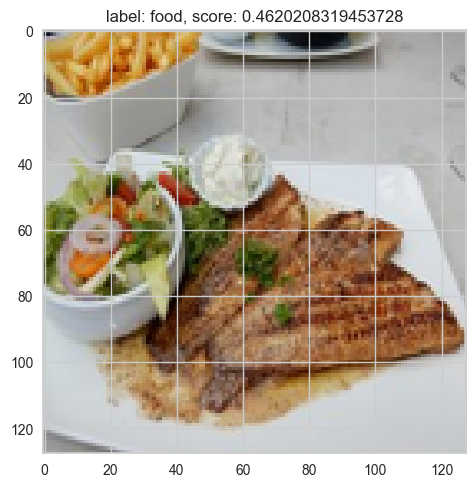

In [146]:
# Get the average score of images that are predicted to be interior
average_interior_score = df_tripadvisor_abc[df_tripadvisor_abc["label"] == "food"]["score"].mean()

# Show 10 images that are labeled as "food"
for i, row in df_tripadvisor_abc[(df_tripadvisor_abc["label"] == "food") & (df_tripadvisor_abc["score"] > average_interior_score)].head(10).iterrows():
    if (images_tripadivsor[i].shape != (49152,)):
        continue
    img = images_tripadivsor[i].reshape((128,128,3))
    plt.imshow(img)
    plt.title(f"label: {row['label']}, score: {row['score']}")
    plt.show()

We can see that the average score for the images that are labelled as 'food' is only 0.12173268660738346. This is actually a low number and thus indicates that the model is not very confident in its predictions to label an image as food. We will now do the same for interior. This is immediatly visible in the pictures shown above. We can see that the model does not do a very good job at filtering out the food from the other pictures.

0.5150821413920513


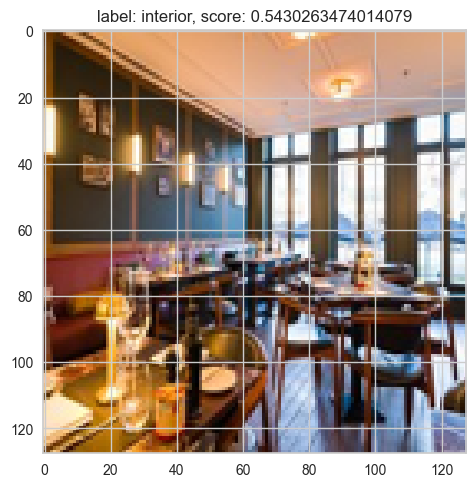

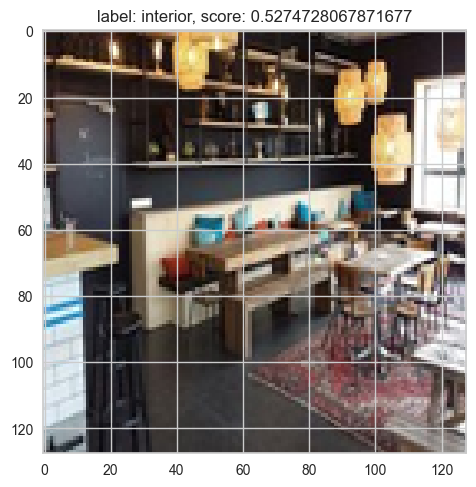

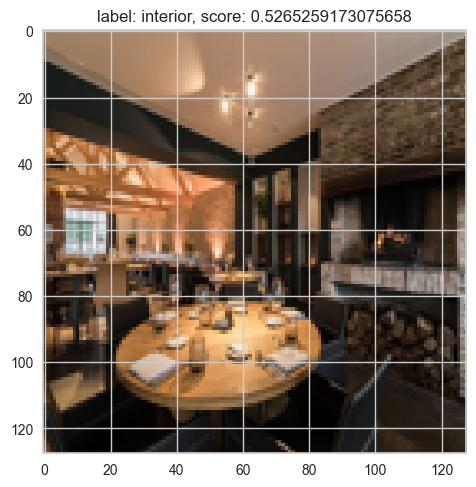

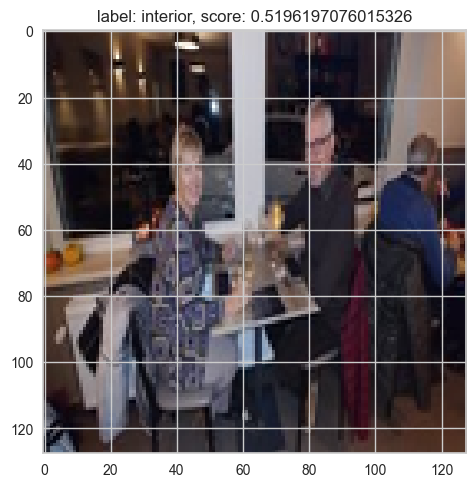

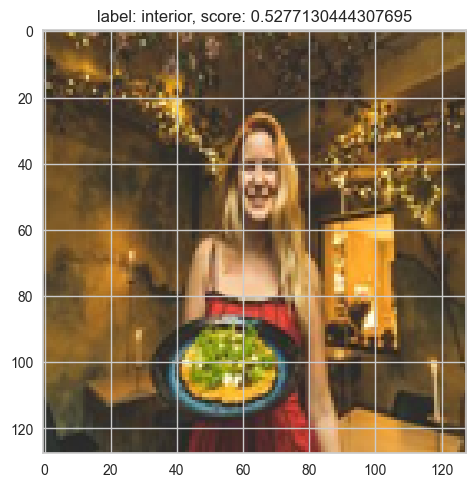

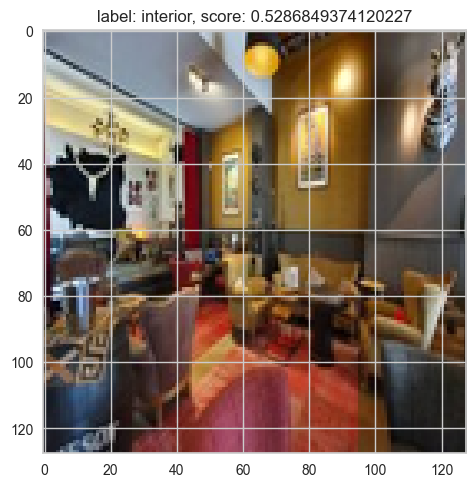

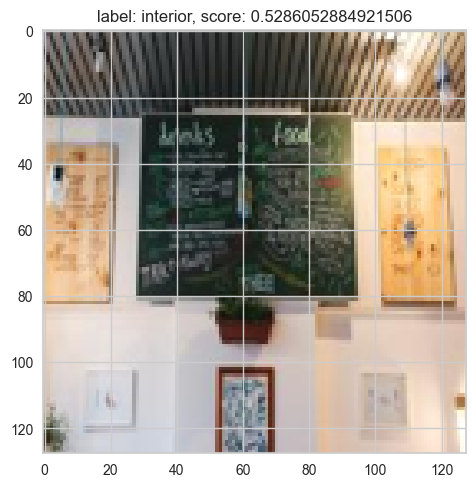

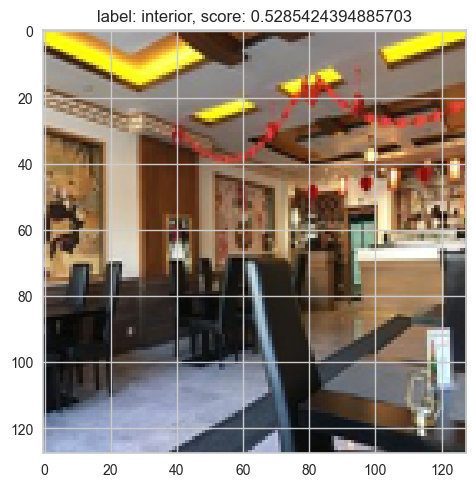

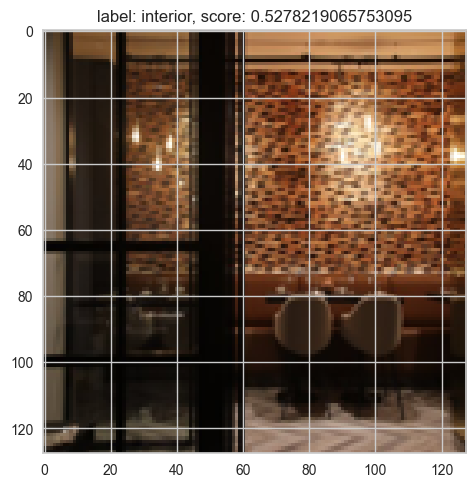

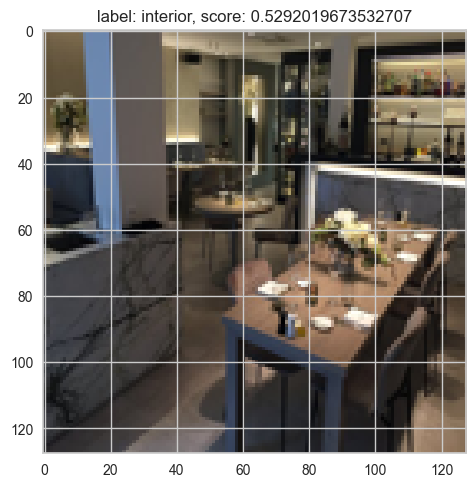

In [145]:
# Get the average score of images that are predicted to be interior
average_interior_score = df_tripadvisor_abc[df_tripadvisor_abc["label"] == "interior"]["score"].mean()

# Show 10 images that are labeled as "food"
for i, row in df_tripadvisor_abc[(df_tripadvisor_abc["label"] == "interior") & (df_tripadvisor_abc["score"] > average_interior_score)].head(10).iterrows():
    if (images_tripadivsor[i].shape != (49152,)):
        continue
    img = images_tripadivsor[i].reshape((128,128,3))
    plt.imshow(img)
    plt.title(f"label: {row['label']}, score: {row['score']}")
    plt.show()

We see that the number here is much higher, which indicates that the model is more confident in its predictions to label an image as interior.

### Conclusion

We can see that all three models have a hard time to distinguish the food images from other images. The interior images are easier to distinguish from other images. This is probably because the interior images are more similar to each other than the food images. The interior images are all pictures of the interior of a restaurant, whilst the food images are all pictures of food, but the food is not always the same. This is why the model is not very confident in its predictions to label an image as food.

We can also conclude that there is a difference between the three models. If we count both averages (from food & interior) togheter we got the highest scores with the AdaBoostClassifier. The RandomForestClassifier and the ExtraTreesClassifier have a lower score. This indicates that the AdaBoostClassifier is the best model to use for this project altough is it far from perfect.

This task can probably be improved alot when using Deep Learning. This might be good to try out in a future sprint.